# NFL 1st and Future - Playing Surface Analytics: The Zoo

Contributors:
* Philipp Singer: https://www.kaggle.com/philippsinger
* Dmitry Gordeev: https://www.kaggle.com/dott1718

![](https://images.unsplash.com/photo-1529663297269-6d349ec39b57?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=1050&q=80)
<font size="2">Source: unsplash.com</font>

## Introduction & Summary

Artificial turf plays a crucial role across modern sports like soccer, baseball, tennis, or also American football. While in 2019 already 12 stadiums of the NFL had an artificial surface, this number will rise to **15 in the 2020 season** [1]. Consequently, it is important to understand what impact artificial turf has on aspects of the sport. One of the most important questions to answer is **whether it has an impact on injury rates**. While previous research has been sometimes inconclusive mostly due to lack of historic data, recent studies [2,3] have shown clear evidence of significantly higher injury rates on artificial turf compared to natural grass. 

Biomechanical studies have shown that synthetic turf surfaces do not release cleats as readily as natural turf [4] meaning that it is a **harder surface than grass and does not have much "give" when forces are placed on it** [5]. Players might thus suffer injuries with a higher rate compared to natural grass as a result of these "unnatural" forces. This theory is directly supported by the fact that ankle and foot injuries have particularly high increases of injury rates on artificial turf vs. natural grass [2]. In respective work, the authors also hypothesize that this effect is related to a "lack of release between a player's shoe and a synthetic turf surface". 

An area that has been previously mostly unexplored, is to study **whether player movement patterns differ across synthetic turf and natural grass**, and if so, whether these differences in play behavior could explain some of the artefacts found when investigating injury rates on different types of surfaces. In this work, we thus tackle this question by studying full player tracking data of 250 players (100 with injuries) over two regular seasons of the NFL. Next, we summarize our research questions, findings and contributions of this work.

1. Statistical tests on injury rates corroborate previous research showing clear evidence that the **risk of an injury is higher on artificial turf**. Utilizing survival analysis (Cox regression), we also find that the risk of getting an injury accumulates much faster on artificial surface. Additionally, we find that artificial turf elevates the risk of non-knee lower limb injuries significantly more which directly supports the findings of [2]. Repeated games on synthetic turf lower the risk of injury, maybe helping players to adjust posture stability or micro-movement patterns to a harder surface.
2. To better understand how injury rates and observed effects differ within the data population at hand, we split the data by a player's roster position. While we find that **injuries on artifical turf are more frequent for each player's position**, the prevalence of this effect differs across player groups. Turf type has the most significant impact on injuries of **Cornerbacks who suffer a 600% higher rate of injuries on artificial turf in comparison to natural grass**.
3. Next, we are interested in studying **whether players' movement patterns differ between synthetic and natural turf** which might be an explanation for observed higher injury rates. To study this and similar questions, we introduce a **flexible neural network model** that allows us to **model movement trajectories** in order to **predict arbitrary aspects of a play** (e.g., type of surface, player role, type of play, etc.). 
4. After demonstrating the **usibility of the model** by successfully predicting the role of a player just by looking at speed and acceleration based features of a movement trajectory, we investigate if **players' movement patterns allow us to predict the surface of the play**. However, our predictive experiments cannot show any strong evidence for such an effect leading to our conclusion that **players do not change their playstyle significantly across surfaces**.

To summarize, we confirm previous research and find that **playing on artificial turf increases the risk of injury**, this risk seems to differ for different types of player roles.
However, we **cannot assume that different playstyles across surfaces are a leading causal effect for the higher rate of injuries on artificial turf**. Coupled with our findings about types of injuries and the insights from previous research, we rather believe that artefacts of the surface such as the lack of release between a player's shoe and a synthetic turf surface have an effect on the injury rates. However, we cannot observe whether a change in playstyle would be necessary in order to reduce the injury risk. Findings such as the fact that injury risks singificantly increase directly after switching from natural grass to synthetic turf could support this theory. Nonetheless, further research is necessary coupled with the need for more detailed data to study more fine-grained aspect of player movements such as posture or micro-movement in further detail.

The rest of this kernel includes all supporting experiments of our work and goes into detail about methodology, experiments, and insights.


In [1]:
# simply change this to "cpu" in order to run on cpu kernels
device = "cuda"

import os
if True:
    os.environ["OMP_NUM_THREADS"] = "1"
    os.environ["MKL_NUM_THREADS"] = "1"
    os.environ["OPENBLAS_NUM_THREADS"] = "1"
    os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
    os.environ["NUMEXPR_NUM_THREADS"] = "1"

!pip install lifelines

import numpy as np
import pandas as pd
import gc
from scipy.stats import norm
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import OneHotEncoder

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from scipy.spatial import Voronoi
import time
import torch
from torch import nn
from tqdm import tqdm_notebook as tqdm
import time
from torch.utils.data import DataLoader, Dataset, TensorDataset
from sklearn.preprocessing import StandardScaler
from random import random
from copy import copy

from joblib import Parallel, delayed
import multiprocessing
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold
from statsmodels.stats.contingency_tables import mcnemar

from lifelines import CoxPHFitter
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

     |████████████████████████████████| 389kB 2.8MB/s 
  Created wheel for autograd: filename=autograd-1.3-cp36-none-any.whl size=47990 sha256=2f7d5fa1e84b7bd363105d456e1ca036921c1c5a35b3299a77f9ac53681a0e1d
  Stored in directory: /tmp/.cache/pip/wheels/42/62/66/1121afe23ff96af4e452e0d15e68761e3f605952ee075ca99f
Successfully built autograd


## Data load

Fortunately, injuries during NFL games are quite rare, however for statistical analysis of the injury reasons it creates additional difficulties. With such low number of injuries it is usually difficult to conduct proper statistical analysis.
Even though data was collected over two full seasons, even 1-2 extra erroneous or missed injury records can drive significance of statistical tests. Out of **105** injury records (counting a double injury case) available, **28** do not have identifier of the corresponding play. Fortunately, we have the data about the game where each injury accured, so, in order to **preserve all injury information** available, we assign the last plays of these games as those which led to the injury. This allows us to conduct statistical analyses on all 105 injury records at hand.

In [2]:
DTYPE = np.float32
FREQ = 3

InjuryRecord = pd.read_csv('../input/nfl-playing-surface-analytics/InjuryRecord.csv')

PlayList = pd.read_csv('../input/nfl-playing-surface-analytics/PlayList.csv')
last_plays = PlayList.groupby('GameID')['PlayKey'].last()
InjuryRecord.loc[InjuryRecord['PlayKey'].isnull(), 'PlayKey'] = InjuryRecord['GameID'].map(last_plays)[InjuryRecord['PlayKey'].isnull()].values
InjuryRecord = InjuryRecord.groupby('PlayKey').first().reset_index()

PlayList = PlayList.merge(InjuryRecord[['PlayKey', 'DM_M1']], left_on='PlayKey', right_on='PlayKey', how='left')
PlayList['DM_M1'] = PlayList['DM_M1'].fillna(0)



PlayerTrackData = pd.read_csv('../input/nfl-playing-surface-analytics/PlayerTrackData.csv',\
                              usecols=["PlayKey", "time", "x", "y", "dir"],\
                              dtype={"time": DTYPE, "x": DTYPE, "y": DTYPE, "dir": DTYPE})
PlayerTrackData['time'] = (PlayerTrackData['time'] * 10).astype(np.int16)
PlayerTrackData = PlayerTrackData[PlayerTrackData['time'] % FREQ == 0]

gc.collect()

PlayerTrackData = PlayerTrackData.merge(PlayList[['PlayKey', 'RosterPosition']], left_on='PlayKey', right_on='PlayKey', how='left')
PlayerTrackData['sx'] = PlayerTrackData['x'].diff().astype(DTYPE) * 10 / FREQ
PlayerTrackData['sy'] = PlayerTrackData['y'].diff().astype(DTYPE) * 10 / FREQ
PlayerTrackData['s'] = np.sqrt(PlayerTrackData['sx']**2 + PlayerTrackData['sy']**2).astype(DTYPE)

PlayerTrackData['ax'] = PlayerTrackData['sx'].diff().astype(DTYPE)
PlayerTrackData['ay'] = PlayerTrackData['sy'].diff().astype(DTYPE)
PlayerTrackData['a'] = np.sqrt(PlayerTrackData['ax']**2 + PlayerTrackData['ay']**2).astype(DTYPE)

PlayerTrackData['sx_prev'] = PlayerTrackData['sx'].shift()
PlayerTrackData['sy_prev'] = PlayerTrackData['sy'].shift()
PlayerTrackData['s_prev'] = PlayerTrackData['s'].shift()

PlayerTrackData = PlayerTrackData[PlayerTrackData['time'] > FREQ].drop(['dir'], axis=1)

PlayerTrackData = PlayerTrackData.merge(PlayList[['PlayKey', 'PlayerKey', 'FieldType']], left_on='PlayKey', right_on='PlayKey')
PlayerTrackData = PlayerTrackData.merge(InjuryRecord[['PlayKey', 'DM_M1']], left_on='PlayKey', right_on='PlayKey', how='left')
PlayerTrackData['DM_M1'] = PlayerTrackData['DM_M1'].fillna(0)

gc.collect()

PlayerTrackData['cos_th'] = ((PlayerTrackData['ax']*PlayerTrackData['sx_prev'] + PlayerTrackData['ay']*PlayerTrackData['sy_prev']) / PlayerTrackData['a'] / PlayerTrackData['s_prev']).fillna(1)
PlayerTrackData['a_fwd'] = PlayerTrackData['a'] * PlayerTrackData['cos_th']
PlayerTrackData['a_sid'] = np.sqrt(PlayerTrackData['a']**2 - PlayerTrackData['a_fwd']**2)
PlayerTrackData['a_sid'] = PlayerTrackData['a_sid'].fillna(0) * np.sign(PlayerTrackData['ax']*PlayerTrackData['sy_prev'] - PlayerTrackData['ay']*PlayerTrackData['sx_prev'])


## Correcting the sample bias

The data provided is a sample of all players in NFL; unfortunately, most of the players who did not suffer any injuries are not available for analysis. However, to properly conduct statistical analytics, we need to account for frequencies of plays on artificial and natural turf. Though it does not have a major impact on statistical tests performed, the resulting injury frequencies are unrealistically high due to us having a rather balanced sample of injured and non-injured players. Therefore, in order to correct the numbers, we calculate a very rough correction term for missing non-injured players and plays. Assuming there are 53 players per team in 32 teams, we estimate there are 1696 players overall, while only 250 players are present in the data. So, for the correction term we assume there are extra 1446 = 1696 - 250 players with same data as non-injured players. We apply it to adjust estimates throughout this kernel if warranted.

In [3]:
corr_term = (32 * 53 - 250) / 250
print("Correction factor:", corr_term)

Correction factor: 5.784


## Playing surface impact on injuries

First, we study the fundamental question whether injury rates differ statistically between games played on artificial turf and natural grass.
An appropriate statistical test to identify if we can claim that players are more prone to injuries when they play on artificial turf is a **chi-squared test** (based on contingency table, other appropriate tests such as Fisher's exact test confirm obtained results). We run the test twice, once to assess how frequent the injuries are **per play**, and second - **per game**. Each test is performed once without and once with the bias correction factor.

In [4]:
def csq_test(df, grp=None, target='DM_M1', c_term=1):
    df0 = df[df[target] >= df.groupby('GameID')[target].cumsum()]
    
    if grp is not None:
        df0 = df0.groupby(grp)['FieldType', target].max().reset_index()
    
    cond = df0['FieldType'] == "Synthetic"

    e1 = df0[cond][target].sum()
    n1 = cond.sum() * c_term
    e2 = df0[~cond][target].sum()
    n2 = (~cond).sum() * c_term
    p_hat = (e1 + e2) / (n1 + n2)
    z = (e1/n1 - e2/n2) / np.sqrt(p_hat * (1-p_hat) * (1/n1 + 1/n2))

    return 1-norm.cdf(z), int(n1+n2), int(e1+e2)

res = csq_test(PlayList, c_term=1)
print(f"p-value by play {res[0]:<6.4f} ({res[2]} injuries from {res[1]} plays)")
res = csq_test(PlayList, grp='GameID', c_term=1)
print(f"p-value by game {res[0]:<6.4f} ({res[2]} injuries from {res[1]} games)")

res = csq_test(PlayList, c_term=corr_term)
print(f"Bias corrected p-value by play {res[0]:<6.4f} ({res[2]} injuries from {res[1]} plays)")
res = csq_test(PlayList, grp='GameID', c_term=corr_term)
print(f"Bias corrected p-value by game {res[0]:<6.4f} ({res[2]} injuries from {res[1]} games)")

p-value by play 0.0045 (104 injuries from 266505 plays)
p-value by game 0.0069 (104 injuries from 5712 games)
Bias corrected p-value by play 0.0045 (104 injuries from 1541464 plays)
Bias corrected p-value by game 0.0073 (104 injuries from 33038 games)


We can see that in both cases p-values are clearly below 0.01, allowing us to reject the null hypothesis and to claim that **the risk of an injury is significantly higher on artifical turf**. Let us further take a look at how injury risk grows when a player accumulates plays/games on artificial turf compared to natural grass. In order to do so, we run a **survival analysis model** using **Cox regression** with the surface type as the only predictor. We run 2 regressions - one is counting number of plays played on a certain type of surface, and the other is counting number of games.

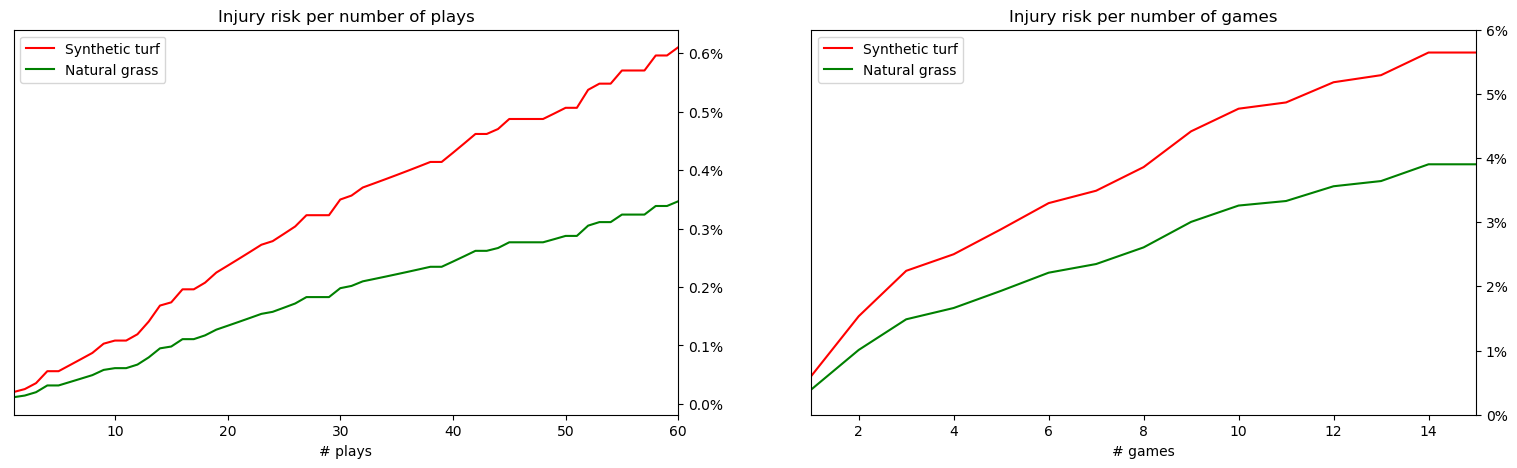

In [5]:
target = 'DM_M1'

# Stop at the first injury
df = PlayList[PlayList[target] >= PlayList.groupby('PlayerKey')[target].cumsum()]
df = df.groupby(['GameID']).last().reset_index()[['PlayerKey', 'PlayKey', 'PlayerGamePlay', target, 'FieldType']]
df['FieldSynthetic'] = (df['FieldType'] == "Synthetic").astype(int)
cph = CoxPHFitter()
cph.fit(df[['FieldSynthetic', 'PlayerGamePlay', target]], duration_col='PlayerGamePlay', event_col=target)

play_preds = (1 - cph.predict_survival_function(pd.DataFrame({"PlayerGamePlay":[0,0], "FieldSynthetic":[0,1]}))[:60]) / corr_term
play_preds.columns = ['Natural grass', 'Synthetic turf']


df = PlayList.groupby(['GameID'])[['PlayerKey', 'FieldType', 'PlayerGame', 'DM_M1']].max().reset_index().sort_values(['PlayerKey', 'PlayerGame'])
df = df[df[target] >= df.groupby('PlayerKey')[target].cumsum()]
df = df.groupby('GameID').last()
df = df.groupby(['PlayerKey', 'FieldType']).apply(lambda z: pd.DataFrame(\
    {"ngames":[len(z)], "DM_M1":[z['DM_M1'].max()]}\
    )).reset_index().drop(['level_2'], axis=1)
df['FieldSynthetic'] = (df['FieldType'] == "Synthetic").astype(int)
cph = CoxPHFitter()
cph.fit(df[['FieldSynthetic', 'ngames', 'DM_M1']], duration_col='ngames', event_col='DM_M1')

game_preds = (1 - cph.predict_survival_function(pd.DataFrame({"PlayerGamePlay":[0,0], "FieldSynthetic":[0,1]}))[:15]) / corr_term
game_preds.columns = ['Natural grass', 'Synthetic turf']


plt.style.use(['default'])
fig = plt.figure(figsize = (15, 5))

ax = plt.subplot(1, 2, 1)
play_preds[['Synthetic turf', 'Natural grass']].plot(colors=['red', 'green'], ax=ax)
ax.yaxis.tick_right()
plt.title('Injury risk per number of plays')
plt.xlabel('# plays')
#plt.ylabel('Injury risk')
ax.yaxis.set_label_position("right")
ax.set_yticklabels(['{:,.1%}'.format(x) for x in ax.get_yticks()])

ax = plt.subplot(1, 2, 2)
game_preds[['Synthetic turf', 'Natural grass']].plot(colors=['red', 'green'], ax=ax)
ax.yaxis.tick_right()
plt.title('Injury risk per number of games')
plt.xlabel('# games')
#plt.ylabel('Injury risk')
ax.yaxis.set_label_position("right")
ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])
plt.ylim((0, 0.06))

plt.subplots_adjust(right=1.1)

plt.show()

In the figures above, the x-axis depict the accumulating number of plays (left) and number of games (right), while the y-axis shows the injury risk for synthetic turf (red) and natural grass (green) as calculated by the survival model. 
As each individual game or play shows higher injury risk on artificial surface, as expected the risk also accumulates much faster over plays/games. **After 60 plays, the risk of an injury on synthetic turf is 0.6% vs. only 0.35% on natural grass.** Similarly, after 15 games, the risk of injury on artificial turf rises to 5.6%, while it is 4% on natural grass.

In [6]:
play_preds

,Natural grass,Synthetic turf
1.0,0.000114,0.000203
2.0,0.000143,0.000253
3.0,0.000200,0.000355
4.0,0.000316,0.000560
5.0,0.000316,0.000560
6.0,0.000374,0.000663
7.0,0.000433,0.000767
8.0,0.000492,0.000872
9.0,0.000582,0.001030
10.0,0.000612,0.001083


In [7]:
game_preds

,Natural grass,Synthetic turf
1.0,0.003925,0.006026
2.0,0.010097,0.015348
3.0,0.014870,0.022426
4.0,0.016632,0.025010
5.0,0.019313,0.028911
6.0,0.022134,0.032977
7.0,0.023485,0.034908
8.0,0.026078,0.038592
9.0,0.030053,0.044167
10.0,0.032598,0.047693


## Types of injuries

Injuries are mainly of two types: **knee** and **non-knee**, where latter is dominated by ankle injuries. 

In [8]:
print(InjuryRecord['BodyPart'].value_counts().to_string())

Knee     48
Ankle    41
Toes      7
Foot      7
Heel      1


Previous research [2] has indicated that ankle and foot injuries have particularly high increases of injury rates on artificial turf vs. natural grass which is what we aim to study next. Limited data available does not let us to confidently draw statistical conclusions by type of the injury. But it is sufficient to gain some interesting insights. 

In [9]:
print("Knee injuries")
PlayList2 = PlayList.merge(InjuryRecord[InjuryRecord['BodyPart'] == 'Knee'][['PlayKey', 'DM_M1']].rename({"DM_M1": "DM_M1_knee"}, axis=1), \
                           left_on='PlayKey', right_on='PlayKey', how='left')
PlayList2['DM_M1_knee'] = PlayList2['DM_M1_knee'].fillna(0)

print(f"\tOn synthetic turf {100*PlayList2[PlayList2['FieldType'] == 'Synthetic']['DM_M1_knee'].mean()/corr_term:6.4f}% per play, "\
      f"{100*PlayList2[PlayList2['FieldType'] == 'Synthetic'].groupby('GameID')['DM_M1_knee'].max().mean()/corr_term:4.2f}% per game")
print(f"\tOn natural grass  {100*PlayList2[PlayList2['FieldType'] != 'Synthetic']['DM_M1_knee'].mean()/corr_term:6.4f}% per play, "\
      f"{100*PlayList2[PlayList2['FieldType'] != 'Synthetic'].groupby('GameID')['DM_M1_knee'].max().mean()/corr_term:4.2f}% per game")
print()

res = csq_test(PlayList2, target='DM_M1_knee')
print(f"\tp-value by play {res[0]:<6.4f}")
#print(f"\tp-value by play {res[0]:<6.4f} ({res[2]} injuries from {res[1]} plays)")
res = csq_test(PlayList2, target='DM_M1_knee', grp='GameID')
print(f"\tp-value by game {res[0]:<6.4f}")
#print(f"\tp-value by game {res[0]:<6.4f} ({res[2]} injuries from {res[1]} games)")
print()


print("Non-knee injuries")
PlayList2 = PlayList.merge(InjuryRecord[InjuryRecord['BodyPart'] != 'Knee'][['PlayKey', 'DM_M1']].rename({"DM_M1": "DM_M1_knee"}, axis=1), \
                           left_on='PlayKey', right_on='PlayKey', how='left')
PlayList2['DM_M1_knee'] = PlayList2['DM_M1_knee'].fillna(0)

print(f"\tOn synthetic turf {100*PlayList2[PlayList2['FieldType'] == 'Synthetic']['DM_M1_knee'].mean()/corr_term:6.4f}% per play, "\
      f"{100*PlayList2[PlayList2['FieldType'] == 'Synthetic'].groupby('GameID')['DM_M1_knee'].max().mean()/corr_term:4.2f}% per game")
print(f"\tOn natural grass  {100*PlayList2[PlayList2['FieldType'] != 'Synthetic']['DM_M1_knee'].mean()/corr_term:6.4f}% per play, "\
      f"{100*PlayList2[PlayList2['FieldType'] != 'Synthetic'].groupby('GameID')['DM_M1_knee'].max().mean()/corr_term:4.2f}% per game")
print()

res = csq_test(PlayList2, target='DM_M1_knee')
print(f"\tp-value by play {res[0]:<6.4f}")
#print(f"\tp-value by play {res[0]:<6.4f} ({res[2]} injuries from {res[1]} plays)")
res = csq_test(PlayList2, target='DM_M1_knee', grp='GameID')
print(f"\tp-value by game {res[0]:<6.4f}")
#print(f"\tp-value by game {res[0]:<6.4f} ({res[2]} injuries from {res[1]} games)")
print()

Knee injuries
	On synthetic turf 0.0038% per play, 0.17% per game
	On natural grass  0.0026% per play, 0.13% per game

	p-value by play 0.1088
	p-value by game 0.1308

Non-knee injuries
	On synthetic turf 0.0050% per play, 0.23% per game
	On natural grass  0.0026% per play, 0.13% per game

	p-value by play 0.0078
	p-value by game 0.0107



We see that both groups show increased injury frequency on synthetic turf, allowing us to conclude that the analysis are not dominated by either of the two. From here onward we will not split the injuries by type.

However another conclusions is clear from the numbers above: **artificial turf elevates the risk of non-knee (ankle, foot) injuries significantly more**. Even the collected number of records is sufficient to claim the statistical significance on this sub-group of injuries alone. It is aligned with the assumption that synthetic surface is "harder" and it puts more "stress" on ankles during the game. It is also worth pointing out that a lower increase in frequency of knee injuries might have the same root causes. Increased "pressure" on ankles might be the reason of higher knee injury risk.

P-values observed are unstable due to low number of recorded cases. When the analysis will be repeated after 1-2 extra seasons of data, we expect p-values of both types of injuries to drop below 0.01. 

## Switching the surface

It is a common observation in sports medicine for players to report more discomfort after the switch from natural surface to an artificial one. As a simplified analysis, a quick check of injury rates split by the surface type of preceding game shows interesting numbers. 

In [10]:
df = PlayList.groupby(['GameID'])[['PlayerKey', 'FieldType', 'PlayerGame', 'DM_M1']].max().reset_index()
df = df[df['DM_M1'] >= df.groupby('PlayerKey')['DM_M1'].cumsum()]
df = df.groupby('GameID').last().reset_index().sort_values(['PlayerKey', 'PlayerGame'])

df['pred_type'] = df['FieldType'].shift()
df = df[df['PlayerGame'] > 1]

df0 = PlayList[PlayList['FieldType'] == 'Synthetic'].groupby('GameID')[['FieldType', 'DM_M1']].max().reset_index()
print(f"Frequency on synthetic {100*df0['DM_M1'].mean() / corr_term:4.2f}% per game, "\
      f"{100*PlayList[PlayList['FieldType'] == 'Synthetic']['DM_M1'].mean() / corr_term:6.4f}% per play "
      f"({int(df0['DM_M1'].sum())} injuries in {int(df0['DM_M1'].count() * corr_term)} games)")
df0 = PlayList[PlayList['FieldType'] != 'Synthetic'].groupby('GameID')[['FieldType', 'DM_M1']].max().reset_index()
print(f"Frequency on natural   {100*df0['DM_M1'].mean() / corr_term:4.2f}% per game, "\
      f"{100*PlayList[PlayList['FieldType'] != 'Synthetic']['DM_M1'].mean() / corr_term:6.4f}% per play "
      f"({int(df0['DM_M1'].sum())} injuries in {int(df0['DM_M1'].count() * corr_term)} games)")
print()

for f_type in df['FieldType'].unique():
    print(f"Previous game on {f_type}")
    
    df1 = df[df['pred_type'] == f_type]
    df0 = df1[df1['FieldType'] == 'Synthetic']
    print(f"\tSynthetic {100*df0['DM_M1'].mean() / corr_term:4.2f}% ({int(df0['DM_M1'].sum())} injuries in {int(df0['DM_M1'].count() * corr_term)} games)")
    df0 = df1[df1['FieldType'] != 'Synthetic']
    print(f"\tNatural   {100*df0['DM_M1'].mean() / corr_term:4.2f}% ({int(df0['DM_M1'].sum())} injuries in {int(df0['DM_M1'].count() * corr_term)} games)")
    print()

Frequency on synthetic 0.40% per game, 0.0088% per play (56 injuries in 13887 games)
Frequency on natural   0.25% per game, 0.0053% per play (48 injuries in 19150 games)

Previous game on Synthetic
	Synthetic 0.39% (21 injuries in 5327 games)
	Natural   0.21% (12 injuries in 5812 games)

Previous game on Natural
	Synthetic 0.53% (31 injuries in 5899 games)
	Natural   0.31% (30 injuries in 9566 games)



We indeed see that **frequency of injuries on synthethic turf are higher when the preceeding game took place on natural grass**. It might be explained that players who had practice on "harder" surfaces are able to better adjust the posture to the surface. However, further research is warranted to study this artefact in more detail.

## Deeper look by player positions

Next, we are interested in studying how injury rates differ after splitting by player positions.

In [11]:
df = PlayList.groupby("GameID")[['DM_M1', 'FieldType', 'RosterPosition']].max().reset_index()
stat = df.groupby('RosterPosition', group_keys=True).apply(lambda z: pd.DataFrame(\
    {"# plays":[len(z)],
     "# injuries":[z['DM_M1'].sum().astype(int)],
     "Inj Natural":[z[z['FieldType'] != "Synthetic"]['DM_M1'].mean()/corr_term],
     "Inj Synthetic":[z[z['FieldType'] == "Synthetic"]['DM_M1'].mean()/corr_term],
     "p-value":[csq_test(df[df['RosterPosition'] == z['RosterPosition'].values[0]])[0]]
    }\
    )).reset_index().drop(['level_1'], axis=1).\
    sort_values("# plays", ascending=False)

stat['p-value'] = stat['p-value'].round(3)
stat["Inj Synthetic"] = stat["Inj Synthetic"].round(6)
stat["Inj Natural"] = stat["Inj Natural"].round(6)
stat["Inj diff"] = ((stat["Inj Synthetic"] / stat["Inj Natural"]).round(2) - 1).fillna(0)

#print(stat.to_string(index=False))
stat.reset_index(drop=True).style.format({
    "Inj Natural": '{:,.2%}'.format,
    "Inj Synthetic": '{:,.2%}'.format,
    "Inj diff": '+{:,.0%}'.format,
})


,RosterPosition,# plays,# injuries,Inj Natural,Inj Synthetic,p-value,Inj diff
0,Linebacker,1101,23,0.34%,0.40%,0.334,+20%
1,Wide Receiver,947,23,0.33%,0.53%,0.132,+58%
2,Offensive Lineman,820,7,0.14%,0.16%,0.415,+18%
3,Safety,781,15,0.32%,0.35%,0.41,+12%
4,Defensive Lineman,721,9,0.18%,0.26%,0.271,+50%
5,Cornerback,573,12,0.10%,0.73%,0.001,+604%
6,Running Back,396,9,0.31%,0.49%,0.244,+58%
7,Tight End,194,6,0.38%,0.88%,0.145,+129%
8,Quarterback,110,0,0.00%,0.00%,nan,+0%
9,Kicker,69,0,0.00%,0.00%,nan,+0%


Firstly, **injuries on artifical turf are more frequent for each player's position**. That brings us to an important conclusion - the higher risk of injuries on artificial turf affects players of every role. In other words, it does not matter if a player is sprinting, rushing through the defensive line or trying to tackle or block an opponent - we see an elevated risk of injury.

However, **the magnitude of the effect depends on a player's position** as imminent from the varying differences between synthetic and natural injury rates per roster position. Turf type has the most significant impact on injuries of **Cornerbacks**, with the disclaimer of having only 12 records of injuries to judge. However, even with such low numbers we see a statistically significant effect (p-value below 0.01) as almost all the recorded injuries happened on artificial turf. Out of the positions with higher number of observations, we see **Wide Receivers** suffering injuries almost 60% more frequently on artificial turf compared to natural grass, with the second lowest p-value. WR and CB injury risk is also correlated with type of the play, as they get more injuries during passing plays where they are more involved, than during rushing plays. 

In [12]:
df = PlayList[['PlayType', 'RosterPosition', 'DM_M1']].copy()
df['PlayType'] = df['PlayType'].apply(lambda x: str(x).split()[0])
df = df[\
    np.logical_and(df['PlayType'].apply(lambda x: str(x)[:7]).isin(['Pass', 'Rush', 'Kickoff']), \
                   df['RosterPosition'].isin(['Cornerback', 'Wide Receiver']))]\
    .groupby(['RosterPosition', 'PlayType']).apply(lambda z: pd.DataFrame(\
    {"# plays":[len(z)],
     "# injuries":[z['DM_M1'].sum().astype(int)],
     "Injuries freq":[z['DM_M1'].mean()/corr_term]
    }\
    ))

df["Injuries freq"] = df["Injuries freq"].round(7)

df.style.format({
    "Injuries freq": '{:,.4%}'.format,
})


## Player movement data

The provided data gives rich information about players' movements: directions, speed, acceleration. One of the main questions of our work is to study effects of player movement on injury rates with a specific focus on differences between playing surfaces. Based on our initial insights in differences between player positions, we expect the movement profile to also depend on a player's position. For example, we expect higher speed and accelerations from WR and CB compared to other positions. To confirm this, we report a simple initial analysis differentiating speed by player position and conduct most of our remaining experiments split by roster position.

In [13]:
df = PlayerTrackData.groupby('PlayKey')[['RosterPosition', 's', 'a', 'a_fwd', 'a_sid', 'DM_M1', 'FieldType']].max().reset_index()

This is an example of how maximum speed per play is differently distributed for some positions.

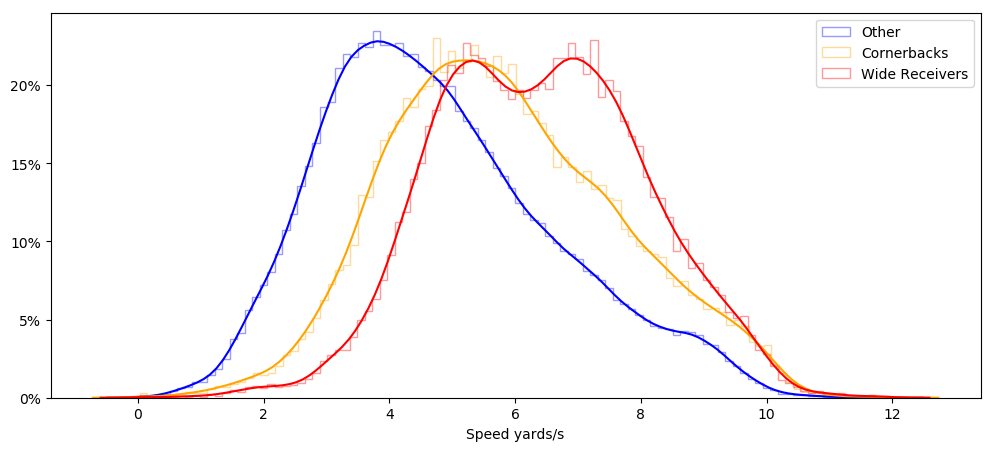

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ft = 's'
nbins = 100

plt.style.use(['default'])
fig = plt.figure(figsize = (12, 5))


df0 = df[df[ft] <= 12]

sns.distplot(df0[~df0['RosterPosition'].isin(['Cornerback', 'Wide Receiver'])][ft], kde=True, norm_hist=True, bins=nbins, hist_kws={"histtype": "step"}, color='blue', label='Other')
sns.distplot(df0[df0['RosterPosition'] == 'Cornerback'][ft], kde=True, norm_hist=True, bins=nbins, hist_kws={"histtype": "step"}, color='orange', label='Cornerbacks')
sns.distplot(df0[df0['RosterPosition'] == 'Wide Receiver'][ft], kde=True, norm_hist=True, bins=nbins, hist_kws={"histtype": "step"}, color='red', label='Wide Receivers')

ax = fig.axes[0]
ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])
plt.xlabel("Speed yards/s")
plt.ylabel("")
plt.legend()

plt.show()

## Play model

Based on our initial insights, we are interested in now studying whether players' movement patterns have predictive power on certain aspects of a play. To that end, we introduce a **flexible neural network** allowing us to **model movement trajectories** in order to **predict arbitrary aspects of a play**. 

The following figure depicts the general architecture of the network. We represent each individual play as a sequence of features over the course of of the trajectory taken (left-hand part of the figure). 
The x-axis represents the individual movement frames at consideration; in our experiments we cut the trajectories after 200 frames. Each frame at interest represents one element of the sequence, and each element can have multiple features which are depicted on the y-axis. We only consider **speed** and **acceleration** based properties of a trajectory, but the data can be arbitrarily extended to other types of features in straight-forward fasion (such as orientation, position, etc.). As an example, the red element of the matrix, captures the acceleration of the player after the third frame at consideration in the movement trajectory of respective play.

On this data representation, the model applies a convolutional layer with a kernel size of 50 and a dimension of 64. This is followed by activation, batch normalization, and average pooling. The final step is then to apply a typical linear layer, and to have the final target classes as outputs. In this visualization, the target consists of three individual classes, but this can be adapted according to the prediction task at hand and we will utilize different targets throughout our experiments shown next.

![Neural Network Architecture](https://i.imgur.com/kuxIzQL.png)

For each of the following experiments, we sample at maximum 10,000 individual plays and run 4-fold player-based cross-validation, meaning that plays of a single player will not overlap between training and validation folds to avoid any leakage. We always report full out-of-fold classification accuracy as well as responsing baseline accuracy always predicting the majority class.

In [15]:
nbags = 1
n_epochs = 50
nfolds = 4

def preprocess(df_base, inplace=False):
    if inplace:
        df = df_base
    else:
        df = df_base.copy()
    
    return df

def pad_sequences(seq, pad=500):

    seq = [i[:pad] for i in seq]
    seq = np.array([i + [-1.]*(pad-len(i)) for i in seq])
    return seq

class FE(BaseEstimator, TransformerMixin):
    def fit(self, train, *_):
        
        return self
    
    def transform(self, df_base, *_):
        
        D_TYPE = np.float32
        df = df_base.copy()
        
        res = {}
        
        pad = 200
        
        s = pad_sequences(df["s"].values)
        a = pad_sequences(df["a"].values)
        sx = pad_sequences(df["sx"].values)
        sy = pad_sequences(df["sy"].values)
        ax = pad_sequences(df["ax"].values)
        ay = pad_sequences(df["ay"].values)
        
        res['sequence'] = np.stack([s, a, sx, sy, ax, ay], axis=2)        
        
        res['target'] = df["target"]

        return res
    


class OwnSampler(torch.utils.data.sampler.Sampler):
    def __init__(self, idx):
        self.idx = idx
    def __iter__(self):
        return iter(self.idx)
    def __len__(self):
        return len(self.idx)

class NFLDataset(Dataset):
    def __init__(self, data,  ds="train", mode="default"):
        fe = FE().fit(data)
            
        self.mode=mode
        
        self.xkeys = ['sequence']
        self.data = fe.transform(data)

        self.num_classes = len(data.target[0])
        self.ds = ds
        self.num_features = {}
        for k in self.xkeys:
            self.num_features[k] = self.data[k].shape[1:]
        
    def __len__(self):
        return len(self.data['target'])

    def __getitem__(self, idx):
        
        if self.mode == "default":
            data = self.data

        row = {k:data[k][idx] for k in self.xkeys}
        
        if self.ds == "train":
            target = np.array(data["target"][idx])
        else:
            target = 0
        
        return {**row, 'target': target}
    
dim = 64

class MyModel(nn.Module):
    def __init__(self, ds_train):
        super(MyModel, self).__init__()
        
        self.cnn = torch.nn.Sequential(
            torch.nn.Conv1d(ds_train.num_features['sequence'][1], dim, 50),
            torch.nn.ReLU(),
            nn.BatchNorm1d(dim, eps=1e-05, momentum=0.1, affine=True),
        )

        self.classifier = torch.nn.Sequential(
            
            torch.nn.Linear(dim, dim),
            torch.nn.ReLU(),
            nn.BatchNorm1d(dim, eps=1e-05, momentum=0.1, affine=True),

            torch.nn.Linear(dim, ds_train.num_classes),

            )
        
    def forward(self, sequence):
        
        sequence = sequence
        
        x = self.cnn(sequence.permute(0,2,1)).permute(0,2,1)
        
        x = F.avg_pool2d(x,(x.shape[1],1)).squeeze(1)
        
        return self.classifier(x)

    
def fit_nn(trn_idx, val_idx, ds_train, ds_val_default, y_train, fold, bag, seed):
        
    torch.manual_seed(seed)
    
    valid_sampler = OwnSampler(val_idx)
    valid_loader = torch.utils.data.DataLoader(ds_val_default, batch_size=64, num_workers=0, sampler=valid_sampler, pin_memory=True)

    train_sampler = torch.utils.data.sampler.SubsetRandomSampler(trn_idx)
    train_loader = torch.utils.data.DataLoader(ds_train, batch_size=128, num_workers=0, sampler=train_sampler, pin_memory=True, drop_last=True)
    
    model = MyModel(ds_train)
    
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.BCEWithLogitsLoss()

    best_score = 0
    best_preds = None
    best_epoch = -1

    start_time = time.time()
    for epoch in range(n_epochs):
        
        s = time.time()

        model.train()
        avg_train_loss = 0
        optimizer.zero_grad()
        
        for idx, data in enumerate(train_loader):
            
            
            
            X = {k:data[k].to(device).float() for k in ds_train.xkeys}
            y = data['target'].to(device).float()

            preds = model(**X)

            loss = criterion(preds, y) 

            loss.backward()

            optimizer.step()
            optimizer.zero_grad()
            avg_train_loss += loss.detach().cpu().numpy() / len(train_loader)


        avg_val_loss = 0
        model.eval()
        all_preds = []
        for idx, data in enumerate(valid_loader):
            X = {k:data[k].to(device).float() for k in ds_train.xkeys}
            y = data['target'].to(device).float()

            preds = model(**X)
            loss = criterion(preds, y) 
            avg_val_loss += loss.detach().cpu().numpy() / len(valid_loader) 
            all_preds.append(preds.detach().cpu())

        all_preds = np.vstack(all_preds)
        
        score = accuracy_score(np.argmax(y_train[val_idx], axis=1), np.argmax(all_preds, axis=1))

        
        if score >= best_score:
            best_score = score
            best_preds = all_preds
            best_epoch = epoch
            #torch.save(model.state_dict(), f"{fold}_{bag}.pt")

        #print(f"{fold:1}:{epoch:2} avg_train_loss {avg_train_loss:<8.4f} avg_val_loss {avg_val_loss:<8.4f} val_accuracy {score:<8.4f}  {time.time()-s:<2.2f}")

    #print(f"fold {fold:1} best {best_score:<8.6f} {best_epoch:3}, {(time.time()-start_time) / n_epochs:<2.2f} s/ep")
    return best_preds, val_idx

In [16]:
df = pd.DataFrame(columns=["Roster position", "Accuracy", "Baseline accuracy"])
def run_model(roster=["Wide Receiver", "Cornerback", "Running Back"], target="RosterPosition", df=None, verbose=True):
    
    np.random.seed(seed=42)
    train = PlayerTrackData[PlayerTrackData.RosterPosition.isin(roster)]
    n_targets = train.RosterPosition.nunique()

    #print(train.RosterPosition.unique())

    try:
        sample = np.random.choice(train.PlayKey.unique(), size=10_000, replace=False)
    except:
        sample = train.PlayKey.unique()

    train = train[train.PlayKey.isin(sample)]

    train["target"] = list(OneHotEncoder(sparse=False).fit_transform(train[target].values.reshape(-1,1)))

    train_agg = train.groupby("PlayKey").agg({'s': lambda x: list(x), 
                                              'a': lambda x: list(x),
                                                'sx': lambda x: list(x), 
                                              'sy': lambda x: list(x), 
                                              'ax': lambda x: list(x), 
                                              'ay': lambda x: list(x), 
                                              'target': lambda x: list(np.mean(x)), 
                                              'PlayerKey': lambda x: max(x)})

    y_train = np.array([np.array(x) for x in train_agg['target'].values])
    
    

    train_processed = preprocess(train_agg, inplace=True)
    ds_train = NFLDataset(train_processed, ds="train", mode="default")

    ds_val_default = copy(ds_train)
    ds_val_default.mode = "default"

    ds_train.num_features

    kf = GroupKFold(n_splits = nfolds)

    start_time = time.time()

    res = Parallel(n_jobs=-1, temp_folder="/tmp", max_nbytes=None, backend="multiprocessing")( \
        delayed(fit_nn)(trn_idx, val_idx, ds_train, ds_val_default, y_train, fold, bag, np.random.randint(100_000)) \
        for fold, (trn_idx, val_idx) in enumerate(kf.split(np.arange(len(train_agg)), groups=train_agg.PlayerKey.values)) \
        for bag in range(nbags))

    from scipy.special import softmax

    oof = np.zeros((len(train_agg), y_train.shape[1]))

    for val, idx in res:
        oof[idx] += softmax(np.array(val), axis=1) / nbags
        
    y_true = np.argmax(y_train,axis=1)
    y_pred = np.argmax(oof, axis=1)
    
    if verbose:
        print("Baseline accuracy:", y_train.mean(axis=0).max())
        print("Full CV Accuracy: {:<8.4f}".format(accuracy_score(y_true, y_pred)))
  
    
    if df is not None:
        df = df.append({"Roster position": roster[0], "Accuracy":  accuracy_score(y_true, y_pred),
                        "Baseline accuracy": y_train.mean(axis=0).max()}, ignore_index=True)
    
    if df is not None:
        return df

To demonstrate the functionality and general predictive power of our model, we first **predict a player's roster position** (limited to *Wide Receiver*, *Cornerback*, and *Running Bac*k) just based on observing speed and acceleration of the corresponding movement trajectory where we already showed earlier that differences in movement patterns seem to exist. 

In [17]:
run_model(roster=["Wide Receiver", "Cornerback", "Running Back"], target="RosterPosition")

Baseline accuracy: 0.5147
Full CV Accuracy: 0.7772  


The results showcase clear predictive power getting close to ~80% accuracy which is significantly higher than a simple baseline accuracy of ~51%. This corroborates our findings from above that player movement patterns differ between separate player positions, even when one just looks at speed and acceleration based features. At the same time, this experiment **demonstrates the usefulness of our proposed neural network model**.

Coming back to one of the main questions of this analytics report, we want to further understand effects between players' movements and injury rates on different types of surfaces. We have already shown that there is a significantly higher injury rate on plays on artificial turf vs. those on natural turf. While we have also showcased that this effect exists across player roles, the prevalance of it is different across various roles. At the same time, we know that players' movement patterns clearly differ between distinct types of players.

Directly predicting if a play leads to an injury is not appropriate due to the very low number of events. However, one of our main questions is 
 **if players' movements show different patterns across playing surfaces** for which we have a lot of data available. To that end, we utilize our flexible model and attempt to **predict the surface just by looking at players' trajectories**. We start by considering all roster positions and predict a play's surface.

In [18]:
run_model(roster=PlayList.RosterPosition.unique(), target="FieldType")

Baseline accuracy: 0.5847
Full CV Accuracy: 0.5897  


We can clearly see that we are unable to outperform a simple baseline model, meaning that most of the trajectory based movement patterns hold no signal in order to predict the surface of a pitch. Based on our insights from above, we now attempt to predict the surface for different roster positions separately.

In [19]:
df = run_model(roster=["Linebacker"], target="FieldType", df=df, verbose=False)
df = run_model(roster=["Offensive Lineman"], target="FieldType", df=df, verbose=False)
df = run_model(roster=["Wide Receiver"], target="FieldType", df=df, verbose=False)
df = run_model(roster=["Safety"], target="FieldType", df=df, verbose=False)
df = run_model(roster=["Defensive Lineman"], target="FieldType", df=df, verbose=False)
df = run_model(roster=["Cornerback"], target="FieldType", df=df, verbose=False)
df = run_model(roster=["Running Back"], target="FieldType", df=df, verbose=False)

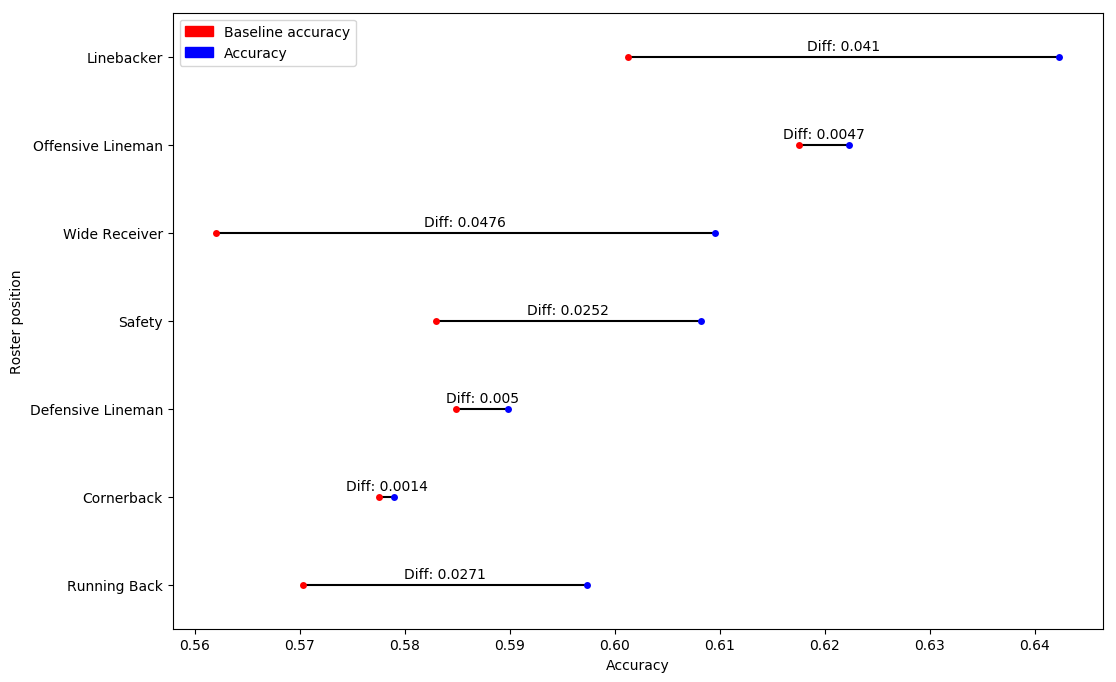

In [20]:
plt.style.use(['default'])
plt.figure(figsize = (12, 8))

sns.swarmplot(x="Baseline accuracy", y="Roster position", data=df, color="red")
sns.swarmplot(x="Accuracy", y="Roster position", data=df, color="blue")

for i in range(len(df)):
    plt.plot([df.iloc[i]["Baseline accuracy"], df.iloc[i]["Accuracy"]], [i,i], color="black")
    t = f'Diff: {np.round((df.iloc[i]["Accuracy"]-df.iloc[i]["Baseline accuracy"]),5)}'
    plt.annotate(t, xy=(df.iloc[i]["Baseline accuracy"]+(df.iloc[i]["Accuracy"]-df.iloc[i]["Baseline accuracy"])/2, i-0.07), ha='center')

p1 = mpatches.Patch(color='red', label='Baseline accuracy')
p2 = mpatches.Patch(color='blue', label='Accuracy')
p = plt.legend(handles=[p1,p2])

This figure presents the summarized accuracy results (x-axis) of running the model of predicting the type of surface for each player role separately (y-axis). Again, we contrast the majority baseline accuracy (red) with the actual achieved accuracy (blue); the lines depict the difference in accuracy. While we can see minor improvements over baseline accuracy, we can at maximum see an improvement of ~5% over the baseline accuracy which is not enough to justify any significant predictive effect and we would rather account it to certain noise in the movement patterns. In the experiment above where we predicted the player role, effects where much stronger and supportive of the hypothesis. However, the slight differences between player roles warrant future investigations with more data. The benefit of our proposed model is its flexibility and that it can be also utilized to study different objectives when looking at player trajectories and also incorporate different features.

To summarize, we cannot find any strong signal in the data for predicting the surface. We thus **cannot find any evidence that players' movement patterns significantly differ between different surfaces** meaning that players do not appear to adapt their behavior based on the type of pitch they play on.

Some observations suggest (but of course, do not claim) that the surface type impacts micro details of player's movement, which might include posture, placement of the feet while running and so on. A single game on synthetic turf might be sufficient for a professional player to adjust such micro details to have a significant impact on the injury risk. In order to test this assumption, more detailed data about players movements is required, such as further sensor data of player movement patterns related to the foot. Also, it would be valuable to access practising data of players in order to study these and similar effects in greater detail.

### Further remarks

* This kernel currently runs on GPU environment. You can easily change the kernel to run on CPU environment by changing the device variable to ``device = "cpu"``. Commenting some of the neural network runs out will also speed up the runtime of the kernel.
* While simple analyses on weather data did not reveal any interesting facets to report, we found that movement patterns do not differ significantly across weather conditions by applying our machine learning play model to predict weather. 
* Another way to split the data is by type of play (rush, pass, etc.). However, the data correlates with player roles and we could not find any interesting additional effects next to those reported.
* We believe that these and similar artefacts of plays can be further studied with our introduced neural network model. There is also still quite some room to improve predictions by e.g., tuning (i) the network architecture, (ii) learning procedure, or (iii) utilized features. For example, in some experiments we replaced the CNN layer with an LSTM layer showcasing similar performance, combining these two types of layers might improve predictive power of the model further. Also, for now we have only considered speed and acceleration based features to not introduce any position-based leakages to the model. Carefully investigating these and other properties of movement such as orientation or direction seems worthy to study in future.

### References

1. https://www.lawnstarter.com/blog/sports-turf/nfl-mlb-teams-artificial-turf-2019/
2. Mack C, Hershman E, Anderson R, et al. Higher rates of lower extremity injury on synthetic turf compared with natural turf among National Football League athletes: epidemiologic confirmation of a biomechanical hypothesis [published online November 19, 2018]. Am J Sports Med. doi:10.1177/0363546518808499
3. Loughran, Galvin J., et al. "Incidence of knee injuries on artificial turf versus natural grass in National Collegiate Athletic Association American football: 2004-2005 through 2013-2014 seasons." The American journal of sports medicine 47.6 (2019): 1294-1301.
4. Kent, Richard, et al. "The mechanics of American football cleats on natural grass and infill-type artificial playing surfaces with loads relevant to elite athletes." Sports biomechanics 14.2 (2015): 246-257.
5. https://orthoinfo.aaos.org/en/diseases--conditions/turf-toe